In [57]:
## Accuracy ground truth Y-label built off of the Buy / Hold / Sell ... 

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import datetime 
import requests
from statistics import mean

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from random import shuffle
import random
random.seed(123)

# import package
import pandas_datareader.data as web
## set start and end dates 
# start = datetime.datetime(2016, 9, 5) 
start = datetime.datetime(2019, 5, 5) 

## end should be no more than 180 days before the current day
end = datetime.datetime(2020, 10, 22) 
## Y label needs 180 days extra for future signal forcasting
end_y = datetime.datetime(2021, 4, 22) 


symbol = 'AAPL'

# extract the closing price data
tsla_df = web.DataReader(['TSLA'], 'yahoo', start = start, end = end)
df = web.DataReader([symbol], 'yahoo', start = start, end = end)
btc_df = web.DataReader(['BTC-USD'], 'yahoo', start = start, end = end)

daily_df_original = df #tsla_df bitcoin_df
weekly_df_original = web.get_data_yahoo(symbol, start = start, end = end ,interval='w')
monthly_df_original = web.get_data_yahoo(symbol, start = start, end = end ,interval='m')

daily_df_original_y = web.DataReader([symbol], 'yahoo', start = start, end = end_y)
stock_close_y = daily_df_original_y['Adj Close']
stock_close_y.columns = {'Close Price'}

stock_close = daily_df_original['Adj Close']
stock_close.columns = {'Close Price'}
daily_df_original.head(10) #daily_df_original

Attributes,Adj Close,Close,High,Low,Open,Volume
Symbols,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,,
2019-05-06,51.050892,52.119999,52.209999,50.875000,51.072498,129772400.0
2019-05-07,49.674709,50.715000,51.855000,50.207500,51.470001,155054800.0
2019-05-08,49.684498,50.724998,51.334999,50.437500,50.474998,105358000.0
2019-05-09,49.150684,50.180000,50.419998,49.165001,50.099998,139634400.0
2019-05-10,48.469784,49.294998,49.712502,48.192501,49.355000,164834800.0
2019-05-13,45.652740,46.430000,47.369999,45.712502,46.927502,229722400.0
2019-05-14,46.375435,47.165001,47.424999,46.352501,46.602501,146118800.0
2019-05-15,46.930973,47.730000,47.937500,46.505001,46.567501,106178800.0


In [58]:
daily_df_original.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 372 entries, 2019-05-06 to 2020-10-22
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   (Adj Close, AAPL)  372 non-null    float64
 1   (Close, AAPL)      372 non-null    float64
 2   (High, AAPL)       372 non-null    float64
 3   (Low, AAPL)        372 non-null    float64
 4   (Open, AAPL)       372 non-null    float64
 5   (Volume, AAPL)     372 non-null    float64
dtypes: float64(6)
memory usage: 20.3 KB


In [59]:
monthly_df_original.tail(5) #aapl_df_monthly

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-06-01,93.095001,79.302498,79.437500,91.199997,3.243376e+09,90.743469
2020-07-01,106.415001,89.144997,91.279999,106.260002,3.020496e+09,105.728088
2020-08-01,131.000000,107.892502,108.199997,129.039993,4.070623e+09,128.394058
2020-09-01,137.979996,103.099998,132.759995,115.809998,3.885767e+09,115.438042
2020-10-01,125.389999,107.720001,117.639999,108.860001,2.895017e+09,108.510361


In [60]:
#### Original data gets manipulated the same was as the copied data here...
# stock_df = daily_df_original
##
# stock_df.drop('Adj Close', inplace=True, axis=1, level=0)
# stock_df.drop('Close', inplace=True, axis=1, level=0)
# stock_df.drop('High', inplace=True, axis=1, level=0)
# stock_df.drop('Low', inplace=True, axis=1, level=0)
# stock_df.drop('Open', inplace=True, axis=1, level=0)
##
# del stock_df['Adj Close']
# del stock_df['Close']
# del stock_df['High']
# del stock_df['Low']
# del stock_df['Open']

## Explicit copied framework of the orignal dataframe, so to only include the same index dates
stock_df = pd.DataFrame(data=None, columns=None, index=daily_df_original.index)


stock_df.tail(5) 

""
Date
2020-10-16
2020-10-19
2020-10-20
2020-10-21
2020-10-22


<AxesSubplot:title={'center':'Adjusted Closing Price'}, xlabel='Date'>

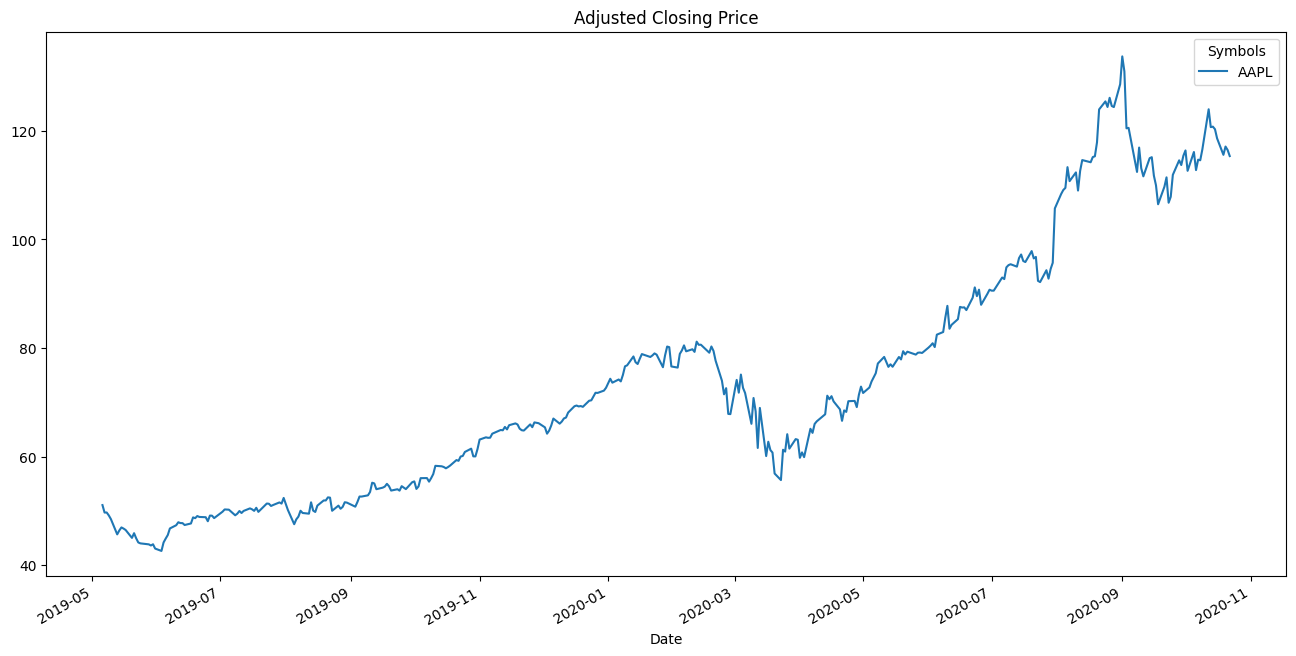

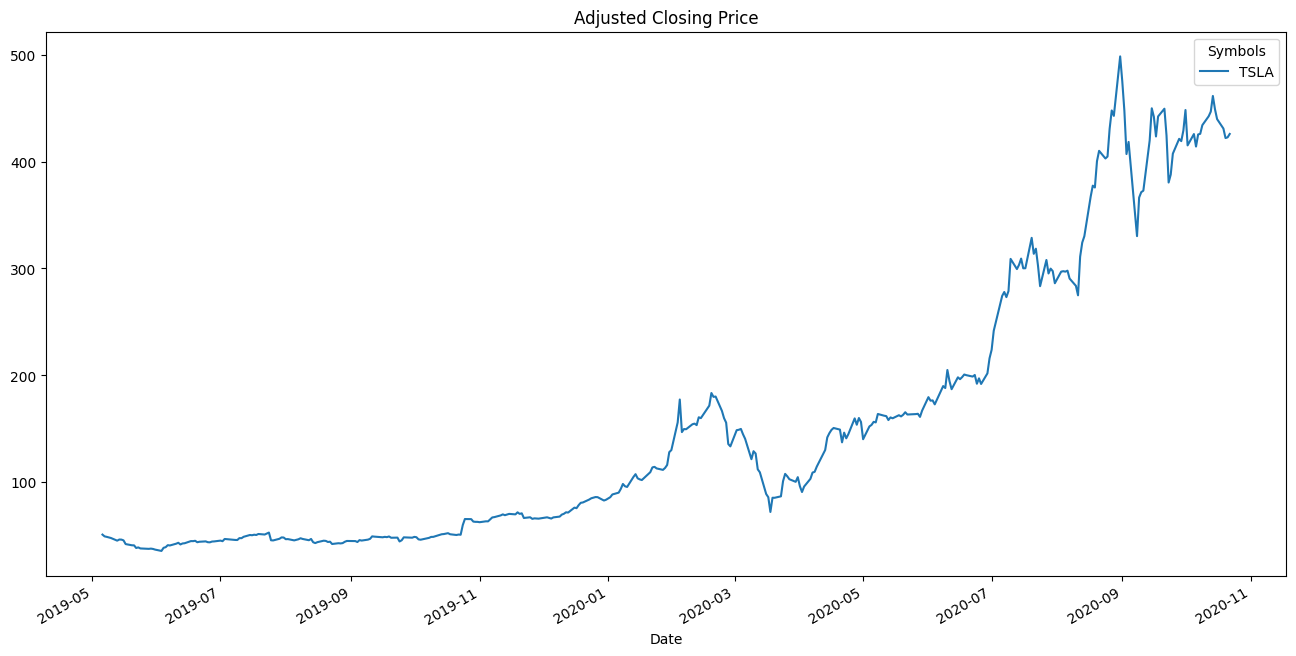

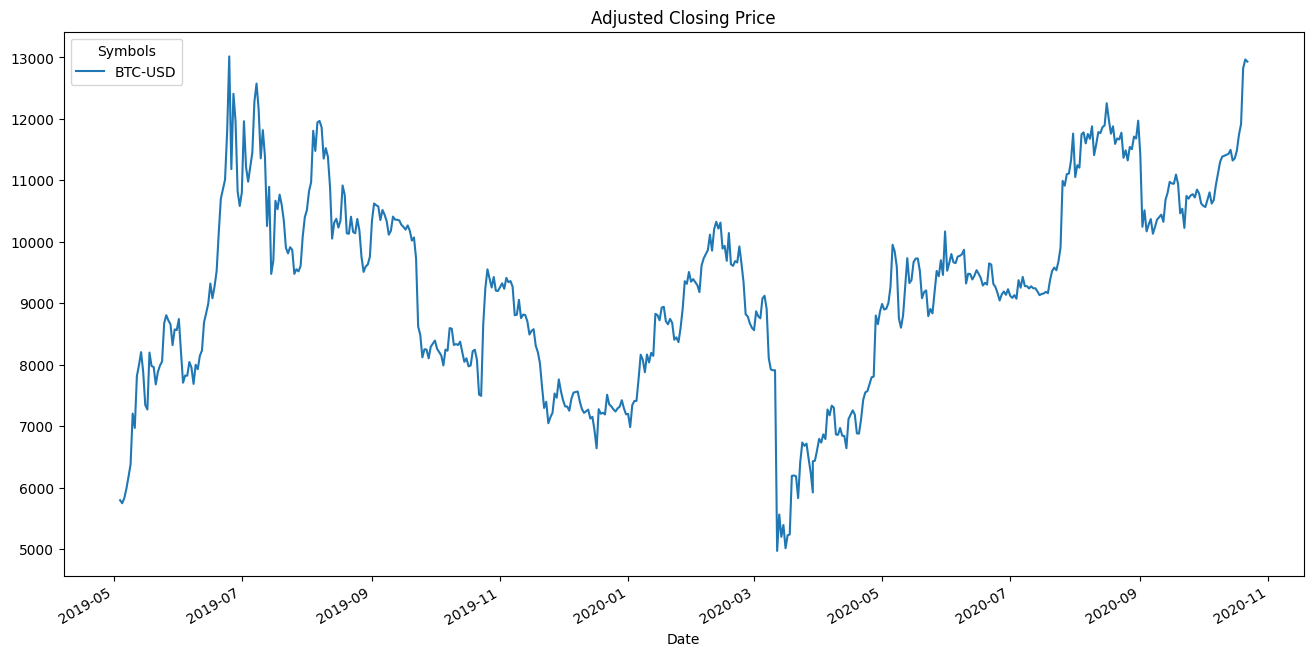

In [61]:
df['Adj Close'].plot(label='Apple',figsize = (16,8),title="Adjusted Closing Price")
tsla_df['Adj Close'].plot(label='Tesla',figsize = (16,8),title="Adjusted Closing Price")
btc_df['Adj Close'].plot(label='Bitcoin',figsize = (16,8),title="Adjusted Closing Price")


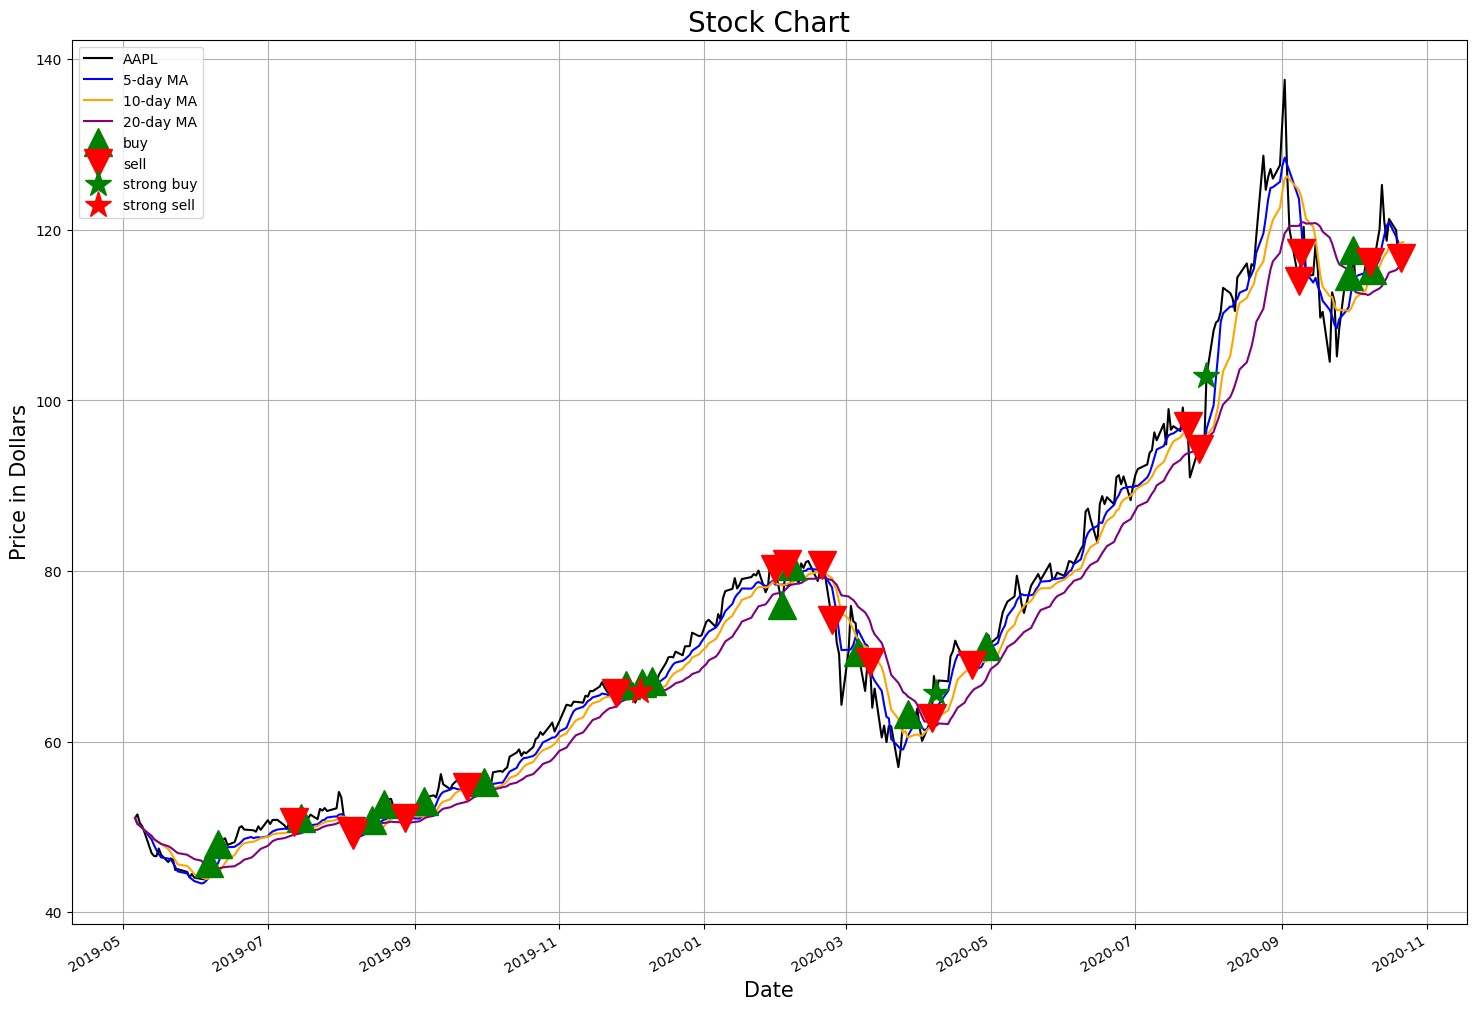

In [62]:
# create 5 days simple moving average column
#stock_MAs = pd.DataFrame()
stock_MAs = pd.DataFrame(data=None, columns=None, index=daily_df_original.index)
stock_MAs['5MA'] = stock_close['Close Price'].rolling(window = 5, min_periods = 1).mean()
# create 10 days simple moving average column
stock_MAs['10MA'] = stock_close['Close Price'].rolling(window = 10, min_periods = 1).mean()
# create 20 days simple moving average column
stock_MAs['20MA'] = stock_close['Close Price'].rolling(window = 20, min_periods = 1).mean()

## When the short term 5-day-moving average crosses above the long term 20-day-
## moving average, this indicates a buy signal "1.0". 
##
## Sell signal is the opposite represented by "0.0".

## 5-MA crossing the 20-MA
stock_df['10MA_Signal'] = 0.0
stock_df['10MA_Signal'] = np.where(stock_MAs['5MA'] > stock_MAs['10MA'], 1.0, 0.0)

## 10-MA crossing the 20-MA
stock_df['20MA_Signal'] = 0.0
stock_df['20MA_Signal'] = np.where(stock_MAs['5MA'] > stock_MAs['20MA'], 1.0, 0.0)


## When ‘XMA_Signal_Change’ = 1, it implies that the XMA_Cross Signal has changed from 0 to 1
## meaning a short-term(faster) moving average has crossed above the
## long-term(slower) moving average, thereby triggering a buy call.
## 
## When ‘XMA_Signal_Change’ = -1, it implies that the XMA_Cross Signal has changed from 1 to 0
## meaning a short-term(faster) moving average has crossed below the
## long-term(slower) moving average, thereby triggering a sell call.
MA10_signal = stock_df['10MA_Signal'].diff()
stock_df['10MA_Signal_Change'] = MA10_signal

MA20_signal = stock_df['20MA_Signal'].diff()
stock_df['20MA_Signal_Change'] = MA20_signal

## 1 means both the 5MA and 10MA have buy signals, whereas -1 means both the 5MA and 10MA have sell signals.
## 0 registers as conclicting opinion between the moving averages.
stock_df['MA_Signal_Change'] = ( MA10_signal + MA20_signal )
#stock_df = stock_df.set_index(daily_df_original.index)

#daily_df_original['MA_Signal_Change'] = ( MA10_signal + MA20_signal )


#plt.figure(figsize = (20,10))
plt.rcParams['figure.figsize'] = [18, 13]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

# plot close price, short-term and long-term moving averages 
daily_df_original['Open'].plot(color = 'k', label= 'Open Price') 
stock_MAs['5MA'].plot(color = 'b',label = '5-day MA') 
stock_MAs['10MA'].plot(color = 'orange', label = '10-day MA')
stock_MAs['20MA'].plot(color = 'purple', label = '20-day MA')

# plot ‘buy’ signals
plt.plot(daily_df_original[stock_df['MA_Signal_Change'] == 1].index, 
         daily_df_original['Open'][stock_df['MA_Signal_Change'] == 1], 
         '^', markersize = 20, color = 'g', label = 'buy')
# plot ‘sell’ signals
plt.plot(daily_df_original[stock_df['MA_Signal_Change'] == -1].index, 
         daily_df_original['Open'][stock_df['MA_Signal_Change'] == -1], 
         'v', markersize = 20, color = 'r', label = 'sell')

# plot ‘strong buy’ signals
plt.plot(daily_df_original[stock_df['MA_Signal_Change'] == 2].index, 
         daily_df_original['Open'][stock_df['MA_Signal_Change'] == 2], 
         '*', markersize = 20, color = 'g', label = 'strong buy')
# plot ‘strong sell’ signals
plt.plot(daily_df_original[stock_df['MA_Signal_Change'] == -2].index, 
         daily_df_original['Open'][stock_df['MA_Signal_Change'] == -2], 
         '*', markersize = 20, color = 'r', label = 'strong sell')

plt.ylabel('Price in Dollars', fontsize = 15 )
plt.xlabel('Date', fontsize = 15 )
plt.title('Stock Chart', fontsize = 20)
plt.legend()
plt.grid()
plt.show()


In [63]:
#### Distance & Rate of Change between the low & high daily stock prices and its 5-day moving average.
stock_df['Distance_of_Low_to_5MA'] = daily_df_original['Low'].subtract(stock_MAs['5MA'], axis='index')
Low_5MA = stock_df['Distance_of_Low_to_5MA'].diff()
stock_df['ROC_of_Low_to_5MA'] = Low_5MA
stock_df['Distance_of_High_to_5MA'] = daily_df_original['High'].subtract(stock_MAs['5MA'], axis='index')
High_5MA = stock_df['Distance_of_Low_to_5MA'].diff()
stock_df['ROC_of_High_to_5MA'] = High_5MA

## Distance & Rate of Change between the low & high daily stock prices and its 10-day moving average.
stock_df['Distance_of_Low_to_10MA'] = daily_df_original['Low'].subtract(stock_MAs['10MA'], axis='index')
Low_10MA = stock_df['Distance_of_Low_to_10MA'].diff()
stock_df['ROC_of_Low_to_5MA'] = Low_10MA
stock_df['Distance_of_High_to_10MA'] = daily_df_original['High'].subtract(stock_MAs['10MA'], axis='index')
High_10MA = stock_df['Distance_of_Low_to_10MA'].diff()
stock_df['ROC_of_High_to_10MA'] = High_10MA

## Distance & Rate of Change between the low & high daily stock prices and its 20-day moving average.
stock_df['Distance_of_Low_to_20MA'] = daily_df_original['Low'].subtract(stock_MAs['20MA'], axis='index')
Low_20MA = stock_df['Distance_of_Low_to_20MA'].diff()
stock_df['ROC_of_Low_to_5MA'] = Low_20MA
stock_df['Distance_of_High_to_20MA'] = daily_df_original['High'].subtract(stock_MAs['20MA'], axis='index')
High_20MA = stock_df['Distance_of_Low_to_20MA'].diff()
stock_df['ROC_of_High_to_10MA'] = High_20MA



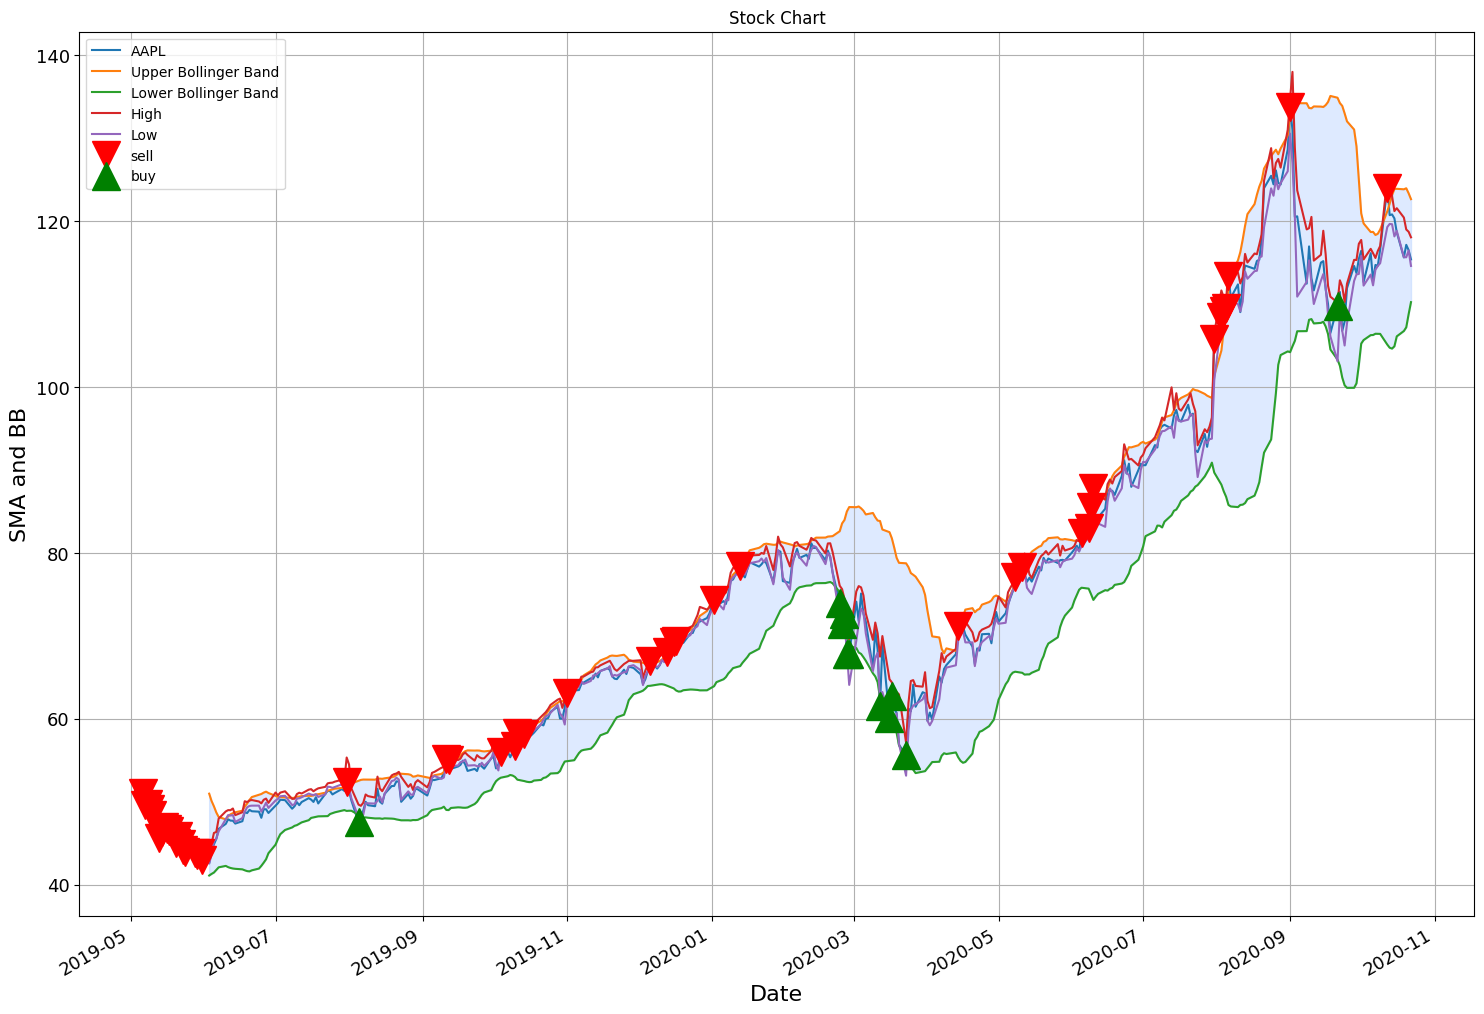

In [64]:
## Bollinger Bands


symbol='AAPL'
# # read csv file, use date as index and read close as a column
# df = pd.read_csv('~/workspace/{}.csv'.format(symbol), index_col='date',
#                  parse_dates=True, usecols=['date', 'close'],
#                  na_values='nan')


# rename the column header with symbol name
bollinger_df = pd.DataFrame(data=None, columns=None, index=daily_df_original.index)
bollinger_df = stock_close.rename(columns={'Close Price': symbol})
bollinger_df.dropna(inplace=True)

# calculate Simple Moving Average with 20 days window
MA20 = bollinger_df.rolling(window=20).mean()

# calculate the standar deviation
STD_DEV = bollinger_df.rolling(window=20).std()

upper_band = MA20 + 2 * STD_DEV
upper_band = upper_band.rename(columns={symbol: 'Upper Bollinger Band'})
lower_band = MA20 - 2 * STD_DEV
lower_band = lower_band.rename(columns={symbol: 'Lower Bollinger Band'})


#high = daily_df_original['High'].rename(columns={symbol: 'High'})


bollinger_df = bollinger_df.join(upper_band).join(lower_band)
bollinger_df['High'] = daily_df_original['High']
bollinger_df['Low'] = daily_df_original['Low']

ax = bollinger_df.plot(title='Stock Chart'.format(symbol),fontsize = 13)
#ax = bollinger_df.plot(title='{} Price and BB'.format(symbol),fontsize = 13)
ax.fill_between(bollinger_df.index, lower_band['Lower Bollinger Band'], upper_band['Upper Bollinger Band'], color='#ADCCFF', alpha=0.4)



## Add the BOLL Signal to the main indicator dataframe

# ##For Upper_BOLL_Signal, a buy signal is represented by 1.0 when the closing daily price hits at/over the high bollinger band.
# High_BOLL = 0
# if bollinger_df.iloc[0][symbol] >= bollinger_df.iloc[0]['Upper Bollinger Band']:
#     High_BOLL = 1.0
# else:
#     High_BOLL = 0.0
# stock_df['High_BOLL_Signal'] = High_BOLL

bollinger_df = bollinger_df.fillna(0)


high_BOLL_labels = []
low_BOLL_labels = []
for price_index in range(len(stock_df)):
    
    if (bollinger_df.iloc[price_index]['Upper Bollinger Band'] == 0) & (bollinger_df.iloc[price_index]['Lower Bollinger Band'] == 0):
        high_BOLL_labels.append(0.0)
        low_BOLL_labels.append(0.0)
    
    ## For Upper_BOLL_Signal, a buy signal is represented by 1.0 when the closing daily price hits at/over the high bollinger band.
    elif bollinger_df.iloc[price_index][symbol] >= bollinger_df.iloc[price_index]['Upper Bollinger Band']: #& (monthly_df.iloc[price_index]['Close'] <= monthly_25th_low_percentile):
        high_BOLL_labels.append(1.0)
        low_BOLL_labels.append(0.0)
    
    ## For Lower_BOLL_Signal, a sell signal is represented by 1.0 when the lowest daily price hits at/below the low bollinger band.
    elif bollinger_df.iloc[price_index][symbol] <= bollinger_df.iloc[price_index]['Lower Bollinger Band']: # & (monthly_df.iloc[0]['Close'] >= monthly_25th_high_percentile):
        low_BOLL_labels.append(1.0)   
        high_BOLL_labels.append(0.0)

    else:
        high_BOLL_labels.append(0.0)
        low_BOLL_labels.append(0.0)
        
        
stock_df['High_BOLL_Signal'] = high_BOLL_labels    
stock_df['Low_BOLL_Signal'] = low_BOLL_labels


# ## For Lower_BOLL_Signal, a sell signal is represented by 1.0 when the lowest daily price hits at/below the low bollinger band.
# #stock_df['Low_BOLL_Signal'] = np.where(daily_df_original['Low'] <= bollinger_df['Lower Bollinger Band'], 1.0, 0.0)
# Low_BOLL = 0
# if bollinger_df.iloc[0][symbol] <= bollinger_df.iloc[0]['Lower Bollinger Band']:
#     Low_BOLL = 1.0
# else:
#     Low_BOLL = 0.0
# stock_df['Low_BOLL_Signal'] = Low_BOLL
# #stock_df['High_BOLL_Signal'] = lower_band


#### Distance between the low, High, and Close daily stock prices and its Low and High Bollinger bands.
stock_df['Distance_of_High_to_High_BOLL'] = daily_df_original['High'].subtract(bollinger_df['Upper Bollinger Band'], axis='index')
High_Price_High_BOLL = stock_df['Distance_of_High_to_High_BOLL'].diff()
stock_df['ROC_of_High_to_High_BOLL'] = High_Price_High_BOLL
stock_df['Distance_of_Close_to_High_BOLL'] = daily_df_original['Adj Close'].subtract(bollinger_df['Upper Bollinger Band'], axis='index')
Close_Price_High_BOLL = stock_df['Distance_of_Close_to_High_BOLL'].diff()
stock_df['ROC_of_Close_to_High_BOLL'] = Close_Price_High_BOLL

stock_df['Distance_of_Low_to_Low_BOLL'] = daily_df_original['Low'].subtract(bollinger_df['Lower Bollinger Band'], axis='index')
Low_Price_Low_BOLL = stock_df['Distance_of_Low_to_Low_BOLL'].diff()
stock_df['ROC_of_Low_to_Low_BOLL'] = Low_Price_Low_BOLL
stock_df['Distance_of_Close_to_Low_BOLL'] = daily_df_original['Adj Close'].subtract(bollinger_df['Lower Bollinger Band'], axis='index')
Close_Price_Low_BOLL = stock_df['Distance_of_Close_to_Low_BOLL'].diff()
stock_df['ROC_of_Close_to_Low_BOLL'] = Close_Price_Low_BOLL



## Graphing

# plot ‘sell’ signals
plt.plot(bollinger_df[bollinger_df[symbol] >= bollinger_df['Upper Bollinger Band']].index, 
         bollinger_df[symbol][bollinger_df[symbol] >= bollinger_df['Upper Bollinger Band']], 
         'v', markersize = 20, color = 'r', label = 'sell')

# # plot ‘buy’ signals
plt.plot(bollinger_df[bollinger_df['Low'] <= bollinger_df['Lower Bollinger Band']].index, 
         bollinger_df[symbol][bollinger_df['Low'] <= bollinger_df['Lower Bollinger Band']], 
         '^', markersize = 20, color = 'g', label = 'buy')

# # plot ‘strong buy’ signals
# plt.plot(daily_df_original[stock_df['EMA_Signal_Change'] >= 2].index, 
#          daily_df_original['Open'][stock_df['EMA_Signal_Change'] >= 2], 
#          '*', markersize = 20, color = 'g', label = 'strong buy')
# # plot ‘strong sell’ signals
# plt.plot(daily_df_original[stock_df['EMA_Signal_Change'] == -2].index, 
#          daily_df_original['Open'][stock_df['EMA_Signal_Change'] <= -2], 
#          '*', markersize = 20, color = 'r', label = 'strong sell')


ax.set_xlabel('Date', fontsize = 16)
ax.set_ylabel('SMA and BB',fontsize = 16)
plt.legend()
ax.grid()
#plt.show()



# # Calculating the standar deviation
# STD_DEV = daily_df_original['Close'].rolling(window=20).std()

# # Calling the 20-day simple moving average
# MA20 = stock_MAs['20MA']

# upper_band = MA20 + 2 * STD_DEV
# stock_df['Upper Bollinger'] = upper_band
# #upper_band = upper_band.rename(columns={symbol: 'upper'})
# lower_band = MA20 - 2 * STD_DEV
# stock_df['Lower Bollinger'] = lower_band
# #lower_band = lower_band.rename(columns={symbol: 'lower'})

# #stock_df = stock_df[upper_band).join(lower_band)
# #ax = df.plot(title='{} Price and BB'.format(symbol))
# ax = daily_df_original.plot(title='Price and BB')
# ax.fill_between(stock_df.index, lower_band, upper_band, color='#ADCCFF', alpha='0.4')
# ax.set_xlabel('Date')
# ax.set_ylabel('SMA and BB')
# ax.grid()
# plt.show()

In [65]:
bollinger_df[50:]

,AAPL,Upper Bollinger Band,Lower Bollinger Band,High,Low
Date,,,,,
2019-07-17,49.986462,50.769355,48.127871,51.272499,50.817501
2019-07-18,50.554291,50.895385,48.193331,51.470001,50.924999
2019-07-19,49.799641,50.915913,48.249744,51.625000,50.590000
2019-07-22,50.937756,51.104037,48.269087,51.807499,50.902500
2019-07-23,51.335976,51.347173,48.278157,52.227501,51.822498
...,...,...,...,...,...
2020-10-16,118.637726,123.885271,106.101677,121.550003,118.809998
2020-10-19,115.607498,123.827961,106.747091,120.419998,115.660004
2020-10-20,117.132591,123.951170,107.192054,118.980003,115.629997


In [66]:
bollinger_df.tail(5)

,AAPL,Upper Bollinger Band,Lower Bollinger Band,High,Low
Date,,,,,
2020-10-16,118.637726,123.885271,106.101677,121.550003,118.809998
2020-10-19,115.607498,123.827961,106.747091,120.419998,115.660004
2020-10-20,117.132591,123.951170,107.192054,118.980003,115.629997
2020-10-21,116.494644,123.345555,108.769537,118.709999,116.449997
2020-10-22,115.378235,122.638860,110.226813,118.040001,114.589996


In [67]:
daily_df_original.tail(10)

Attributes,Adj Close,Close,High,Low,Open,Volume
Symbols,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,,
2020-10-09,116.594315,116.970001,117.000000,114.919998,115.279999,100506900.0
2020-10-12,124.000458,124.400002,125.180000,119.279999,120.059998,240226800.0
2020-10-13,120.711044,121.099998,125.389999,119.650002,125.269997,262330500.0
2020-10-14,120.800766,121.190002,123.029999,119.620003,121.000000,151062300.0
2020-10-15,120.322304,120.709999,121.199997,118.150002,118.720001,112559200.0
2020-10-16,118.637726,119.019997,121.550003,118.809998,121.279999,115393800.0
2020-10-19,115.607498,115.980003,120.419998,115.660004,119.959999,120639300.0
2020-10-20,117.132591,117.510002,118.980003,115.629997,116.199997,124423700.0


In [68]:
stock_df.tail(10)

,10MA_Signal,20MA_Signal,10MA_Signal_Change,20MA_Signal_Change,MA_Signal_Change,Distance_of_Low_to_5MA,ROC_of_Low_to_5MA,Distance_of_High_to_5MA,ROC_of_High_to_5MA,Distance_of_Low_to_10MA,...,High_BOLL_Signal,Low_BOLL_Signal,Distance_of_High_to_High_BOLL,ROC_of_High_to_High_BOLL,Distance_of_Close_to_High_BOLL,ROC_of_Close_to_High_BOLL,Distance_of_Low_to_Low_BOLL,ROC_of_Low_to_Low_BOLL,Distance_of_Close_to_Low_BOLL,ROC_of_Close_to_Low_BOLL
Date,,,,,,,,,,,,,,,,,,,,,
2020-10-09,1.0,1.0,1.0,0.0,1.0,-0.045566,0.082300,2.034436,-0.457460,0.154789,...,0.0,0.0,-1.980682,0.089694,-2.386367,1.483272,8.519890,0.344903,10.194206,2.008477
2020-10-12,1.0,1.0,0.0,0.0,0.0,2.739508,3.909452,8.639510,2.785074,3.573820,...,1.0,0.0,4.005988,5.986670,2.826445,5.212812,14.172124,5.652234,18.892583,8.698377
2020-10-13,1.0,1.0,0.0,0.0,0.0,1.526613,0.092896,7.266611,-1.212895,3.245075,...,0.0,0.0,3.288312,-0.717676,-1.390643,-4.217089,14.915589,0.743465,15.976632,-2.915951
2020-10-14,1.0,1.0,0.0,0.0,0.0,0.278539,-0.481544,3.688535,-1.248074,2.678804,...,0.0,0.0,-0.083502,-3.371814,-2.312735,-0.922092,14.994313,0.078724,16.175076,0.198444
2020-10-15,1.0,1.0,0.0,0.0,0.0,-2.335776,-1.986836,0.714220,-2.614314,0.818062,...,0.0,0.0,-2.668785,-2.585283,-3.546478,-1.233743,13.245924,-1.748389,15.418226,-0.756850
2020-10-16,1.0,1.0,0.0,0.0,0.0,-2.084462,0.052952,0.655544,0.251314,0.879986,...,0.0,0.0,-2.335268,0.333518,-5.247545,-1.701067,12.708321,-0.537603,12.536049,-2.882177
2020-10-19,1.0,1.0,0.0,0.0,0.0,-3.555864,-3.444046,1.204131,-1.471402,-2.218176,...,0.0,0.0,-3.407963,-1.072695,-8.220463,-2.972918,8.912912,-3.795409,8.860407,-3.675642
2020-10-20,1.0,1.0,0.0,0.0,0.0,-2.870180,-0.314092,0.479826,0.685684,-2.681786,...,0.0,0.0,-4.971166,-1.563203,-6.818579,1.401884,8.437943,-0.474969,9.940537,1.080131
2020-10-21,0.0,1.0,-1.0,0.0,-1.0,-1.188956,0.334066,1.071046,1.681224,-2.040211,...,0.0,0.0,-4.635556,0.335610,-6.850911,-0.032332,7.680460,-0.757483,7.725108,-2.215430


In [69]:
#     Compare_Stocks = pd.DataFrame(columns=["Company", "Days_Observed", "Crosses", "True_Positive", "False_Positive", "True_Negative", "False_Negative", "Sensitivity","Specificity", "Accuracy", "TPR", "FPR"]) 
#     count =0
#     #stocks = [aapl_df,tsla_df,bitcoin_df]
#     stock_names = [("Apple",aapl_df),("Tesla",tsla_df),("Bitcoin",btc_df)]
#     for index_stock,stock in enumerate(stock_names):
#         # Constants for the stock that we will be updating later
#         Company = stock_names[index_stock][0]
#         stock_df = stock_names[index_stock][1]
Days_Observed = 0
Crosses = 0
#         True_Positive = 0
#         False_Positive = 0
#         True_Negative = 0
#         False_Negative = 0
#         Sensitivity = 0
#         Specificity = 0
#         Accuracy = 0
# This list holds the closing prices of a stock
prices = []
c = 0
# Add the closing prices to the prices list and make sure we start at greater than 2 dollars to reduce outlier calculations.
while c < len(daily_df_original):
    if daily_df_original.iloc[c,4] > float(2.00):  # Check that the closing price for this day is greater than $2.00
        prices.append(daily_df_original.iloc[c,1])
    c += 1
prices_df = pd.DataFrame(data=prices, columns=None, index=daily_df_original.index)
#prices_df = pd.DataFrame(prices)  # Make a dataframe from the prices list

# Calculate exponentiall weighted moving averages:
EMA12 = daily_df_original.ewm(span=12).mean()
EMA26 = daily_df_original.ewm(span=26).mean()
MACD = []  # List to hold the MACD line values
counter=0  # Loop to substantiate the MACD line
while counter < (len(EMA12)):
    MACD.append(EMA12.iloc[counter,0] - EMA26.iloc[counter,0])  # Subtract the 26 day EMA from the 12 day.
    counter += 1
    
MACD_df = pd.DataFrame(data=MACD, columns=None, index=daily_df_original.index)
#MACD_df = pd.DataFrame(MACD)
#MACD_df["MACD"]z
EMA9_on_MACD_df = MACD_df.ewm(span=9).mean() # Create the signal line, which is a 9 day EMA for signal smoothing
EMA9_MACD = EMA9_on_MACD_df.values.tolist()  # Add the signal line values to a list.
#  Loop to Compare the expected MACD crosses results to the actual results
Day = 1
while Day < len(MACD)-5: # -1 to be able to use the last day for prediction, -5 so we can look at the 5 day post average.
    Prev_Day = Day-1
    # Avg_Closing_Next_Days = (prices[Day+1] + prices[Day+2] + prices[Day+3] + prices[Day+4] + prices[Day+5])/5 # To use 5 day average as a decision.
    Avg_Closing_Next_Days = (prices[Day+1] + prices[Day+2] + prices[Day+3])/3  # To use 3 day average as a decision.
    Days_Observed += 1  # Count how many days were observed
    
    
    if ((EMA9_MACD[Prev_Day] > MACD[Prev_Day]) and (EMA9_MACD[Day] <= MACD[Day])):  # when the signal line dips below the MACD line (Expected increase over the next x days)
        Crosses += 1   # register that a cross occurred

        ## 12-EMA crossing the 26-EMA
        stock_df['MACD_Signal'] = 1.0
        MACD_change = stock_df['MACD_Signal'].diff()
        stock_df['MACD_Signal_Change'] = MACD_change
        
        #stock_df['MACD_Cross'] = np.where(stock_df['5_MA'] > stock_df['20_MA'], 1.0, 0.0)

#                 if (prices[Day] < Avg_Closing_Next_Days):  # Tests if the price increases over the next x days.
#                     True_Positive += 1
#                 else:
#                     False_Negative += 1

    if ((EMA9_MACD[Prev_Day] < MACD[Prev_Day]) and (EMA9_MACD[Day] >= MACD[Day])): # when the signal line moves above the MACD line (Expected dip over the next x days)
        Crosses += 1

        ## 26-EMA crossing the 12-EMA
        stock_df['MACD_Signal'] = -1.0
        MACD_change = stock_df['MACD_Signal'].diff()
        stock_df['MACD_Signal_Change'] = MACD_change

#                 if (prices[Day] > Avg_Closing_Next_Days):  # Tests if the price decreases over the next x days.
#                     True_Negative += 1
#                 else:
#                     False_Positive += 1
    Day += 1
    
    ## Measure the distance and rate of change between indicators.
    stock_df['Distance_of_Close_to_Future_MACD'] = daily_df_original['Adj Close'].subtract(Avg_Closing_Next_Days, axis='index')
    Close_MACD = stock_df['Distance_of_Close_to_Future_MACD'].diff()
    stock_df['ROC_of_Close_to_Future_MACD'] = Close_MACD
    
    stock_df['Distance_of_EMA9_to_MACD'] = EMA9_on_MACD_df.subtract(MACD[Day], axis='index') #daily_df_original['Adj Close'].subtract(Avg_Closing_Next_Days, axis='index')
    EMA9_MACD = stock_df['Distance_of_EMA9_to_MACD'].diff()
    stock_df['ROC_of_EMA9_to_MACD'] = EMA9_MACD


#         try:
#             Sensitivity = (True_Positive / (True_Positive + False_Negative)) # Calculate sensitivity
#         except ZeroDivisionError:  # Catch the divide by zero error
#             Sensitivity = 0
#         try:
#             Specificity = (True_Negative / (True_Negative + False_Positive)) # Calculate specificity
#         except ZeroDivisionError:
#             Specificity
#         try:
#             Accuracy = (True_Positive + True_Negative) / (True_Negative + True_Positive + False_Positive + False_Negative) # Calculate accuracy
#         except ZeroDivisionError:
#             Accuracy = 0
#         TPR = Sensitivity  # Calculate the true positive rate
#         FPR = 1 - Specificity  # Calculate the false positive rate

        # Create a row to add to the compare_stocks
#         add_row = {'Company' : Company, 'Days_Observed' : Days_Observed, 'Crosses' : Crosses, 'True_Positive' : True_Positive, 'False_Positive' : False_Positive, 
#         'True_Negative' : True_Negative, 'False_Negative' : False_Negative, 'Sensitivity' : Sensitivity, 'Specificity' : Specificity, 'Accuracy' : Accuracy, 'TPR' : TPR, 'FPR' : FPR}
#         Compare_Stocks = Compare_Stocks.append(add_row, ignore_index = True) # Add the analysis on the stock to the existing Compare_Stocks dataframe
#         count += 1
#     Compare_Stocks.to_csv("All_Stocks.csv", index = False)  # Save the compiled data on each stock to a csv - All_Stocks.csv

In [70]:
stock_df.tail(10)

,10MA_Signal,20MA_Signal,10MA_Signal_Change,20MA_Signal_Change,MA_Signal_Change,Distance_of_Low_to_5MA,ROC_of_Low_to_5MA,Distance_of_High_to_5MA,ROC_of_High_to_5MA,Distance_of_Low_to_10MA,...,Distance_of_Low_to_Low_BOLL,ROC_of_Low_to_Low_BOLL,Distance_of_Close_to_Low_BOLL,ROC_of_Close_to_Low_BOLL,Distance_of_Close_to_Future_MACD,ROC_of_Close_to_Future_MACD,Distance_of_EMA9_to_MACD,ROC_of_EMA9_to_MACD,MACD_Signal,MACD_Signal_Change
Date,,,,,,,,,,,,,,,,,,,,,
2020-10-09,1.0,1.0,1.0,0.0,1.0,-0.045566,0.082300,2.034436,-0.457460,0.154789,...,8.519890,0.344903,10.194206,2.008477,-0.909019,1.993576,-1.793476,0.096866,1.0,0.0
2020-10-12,1.0,1.0,0.0,0.0,0.0,2.739508,3.909452,8.639510,2.785074,3.573820,...,14.172124,5.652234,18.892583,8.698377,6.497124,7.406143,-1.564478,0.228998,1.0,0.0
2020-10-13,1.0,1.0,0.0,0.0,0.0,1.526613,0.092896,7.266611,-1.212895,3.245075,...,14.915589,0.743465,15.976632,-2.915951,3.207710,-3.289413,-1.317320,0.247158,1.0,0.0
2020-10-14,1.0,1.0,0.0,0.0,0.0,0.278539,-0.481544,3.688535,-1.248074,2.678804,...,14.994313,0.078724,16.175076,0.198444,3.297432,0.089722,-1.071041,0.246279,1.0,0.0
2020-10-15,1.0,1.0,0.0,0.0,0.0,-2.335776,-1.986836,0.714220,-2.614314,0.818062,...,13.245924,-1.748389,15.418226,-0.756850,2.818970,-0.478462,-0.847155,0.223887,1.0,0.0
2020-10-16,1.0,1.0,0.0,0.0,0.0,-2.084462,0.052952,0.655544,0.251314,0.879986,...,12.708321,-0.537603,12.536049,-2.882177,1.134392,-1.684578,-0.677724,0.169431,1.0,0.0
2020-10-19,1.0,1.0,0.0,0.0,0.0,-3.555864,-3.444046,1.204131,-1.471402,-2.218176,...,8.912912,-3.795409,8.860407,-3.675642,-1.895836,-3.030228,-0.601846,0.075878,1.0,0.0
2020-10-20,1.0,1.0,0.0,0.0,0.0,-2.870180,-0.314092,0.479826,0.685684,-2.681786,...,8.437943,-0.474969,9.940537,1.080131,-0.370743,1.525093,-0.566617,0.035228,1.0,0.0
2020-10-21,0.0,1.0,-1.0,0.0,-1.0,-1.188956,0.334066,1.071046,1.681224,-2.040211,...,7.680460,-0.757483,7.725108,-2.215430,-1.008690,-0.637947,-0.571340,-0.004722,1.0,0.0


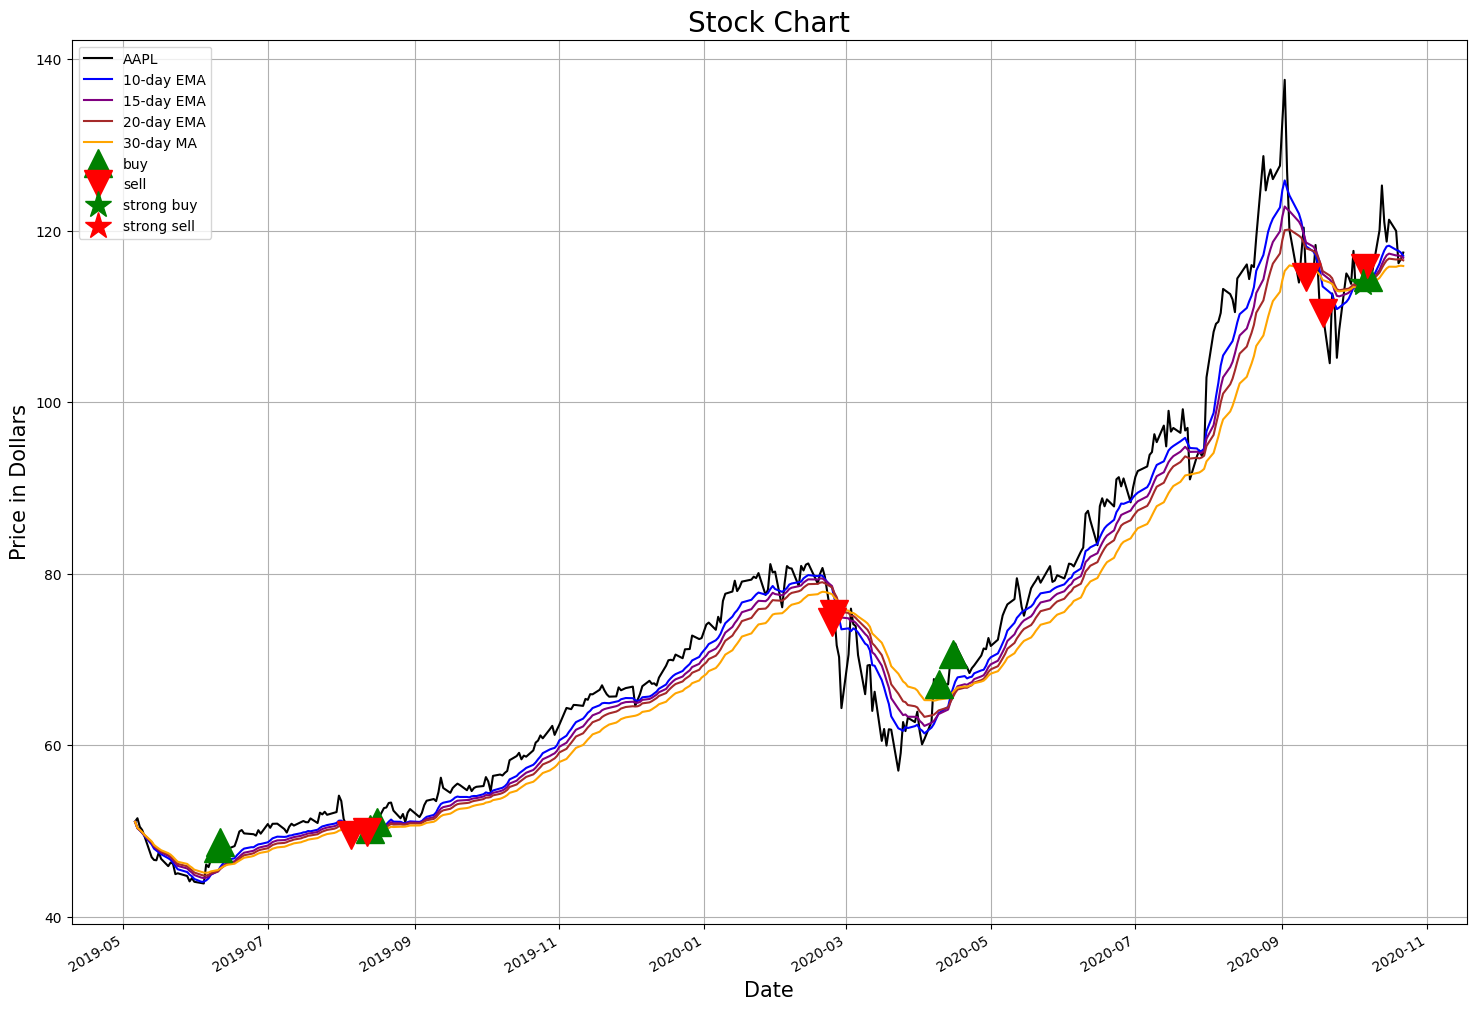

In [71]:
## Exponential Weighted Moving Average Cross-Over Strategy

## Make the EMAs
stock_EMAs = pd.DataFrame()

stock_EMAs['EMA10'] = stock_close['Close Price'].ewm(span=10).mean()
stock_EMAs['EMA15'] = stock_close['Close Price'].ewm(span=15).mean()
stock_EMAs['EMA20'] = stock_close['Close Price'].ewm(span=20).mean()
stock_EMAs['EMA30'] = stock_close['Close Price'].ewm(span=30).mean()

## 10-EMA crossing the slower 15-EMA
stock_df['15EMA_Signal'] = 0.0
stock_df['15EMA_Signal'] = np.where(stock_EMAs['EMA10'] > stock_EMAs['EMA15'], 1.0, 0.0)

## 10-EMA crossing the slower 20-EMA
stock_df['20EMA_Signal'] = 0.0
stock_df['20MA_Signal'] = np.where(stock_EMAs['EMA10'] > stock_EMAs['EMA20'], 1.0, 0.0)

## 10-EMA crossing the slower 30-EMA
stock_df['30EMA_Signal'] = 0.0
stock_df['30EMA_Signal'] = np.where(stock_EMAs['EMA10'] > stock_EMAs['EMA30'], 1.0, 0.0)


## When ‘XMA_Signal_Change’ = 1, it implies that the XMA_Cross Signal has changed from 0 to 1
## meaning a short-term(faster) moving average has crossed above the
## long-term(slower) moving average, thereby triggering a buy call.
## 
## When ‘XMA_Signal_Change’ = -1, it implies that the XMA_Cross Signal has changed from 1 to 0
## meaning a short-term(faster) moving average has crossed below the
## long-term(slower) moving average, thereby triggering a sell call.
EMA15_signal = stock_df['15EMA_Signal'].diff()
stock_df['15EMA_Signal_Change'] = EMA15_signal

EMA20_signal = stock_df['20EMA_Signal'].diff()
stock_df['15EMA_Signal_Change'] = EMA20_signal

EMA30_signal = stock_df['30EMA_Signal'].diff()
stock_df['15EMA_Signal_Change'] = EMA30_signal

## 1 means both the 5MA and 10MA have buy signals, whereas -1 means both the 5MA and 10MA have sell signals.
## 0 registers as conclicting opinion between the moving averages.
stock_df['EMA_Signal_Change'] = EMA15_signal + EMA20_signal + EMA30_signal



#plt.figure(figsize = (20,10))
plt.rcParams['figure.figsize'] = [18, 13]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

# plot close price, short-term and long-term moving averages 
daily_df_original['Open'].plot(color = 'k', label= 'Open Price') 
stock_EMAs['EMA10'].plot(color = 'b',label = '10-day EMA') 
stock_EMAs['EMA15'].plot(color = 'purple',label = '15-day EMA') 
stock_EMAs['EMA20'].plot(color = 'brown', label = '20-day EMA')
stock_EMAs['EMA30'].plot(color = 'orange', label = '30-day MA')

# plot ‘buy’ signals
plt.plot(daily_df_original[stock_df['EMA_Signal_Change'] == 1].index, 
         daily_df_original['Open'][stock_df['EMA_Signal_Change'] == 1], 
         '^', markersize = 20, color = 'g', label = 'buy')
# plot ‘sell’ signals
plt.plot(daily_df_original[stock_df['EMA_Signal_Change'] == -1].index, 
         daily_df_original['Open'][stock_df['EMA_Signal_Change'] == -1], 
         'v', markersize = 20, color = 'r', label = 'sell')

# plot ‘strong buy’ signals
plt.plot(daily_df_original[stock_df['EMA_Signal_Change'] >= 2].index, 
         daily_df_original['Open'][stock_df['EMA_Signal_Change'] >= 2], 
         '*', markersize = 20, color = 'g', label = 'strong buy')
# plot ‘strong sell’ signals
plt.plot(daily_df_original[stock_df['EMA_Signal_Change'] == -2].index, 
         daily_df_original['Open'][stock_df['EMA_Signal_Change'] <= -2], 
         '*', markersize = 20, color = 'r', label = 'strong sell')

plt.ylabel('Price in Dollars', fontsize = 15 )
plt.xlabel('Date', fontsize = 15 )
plt.title('Stock Chart', fontsize = 20)
plt.legend()
plt.grid()
plt.show()



## Check Volatility by tallying the crosses done in a 5-day span.
## Each cross can generate +1 Volatility point, and each day subtracts 0.2 until it hits 0. 
## Or it can have a half-life of 2 or 3 days...

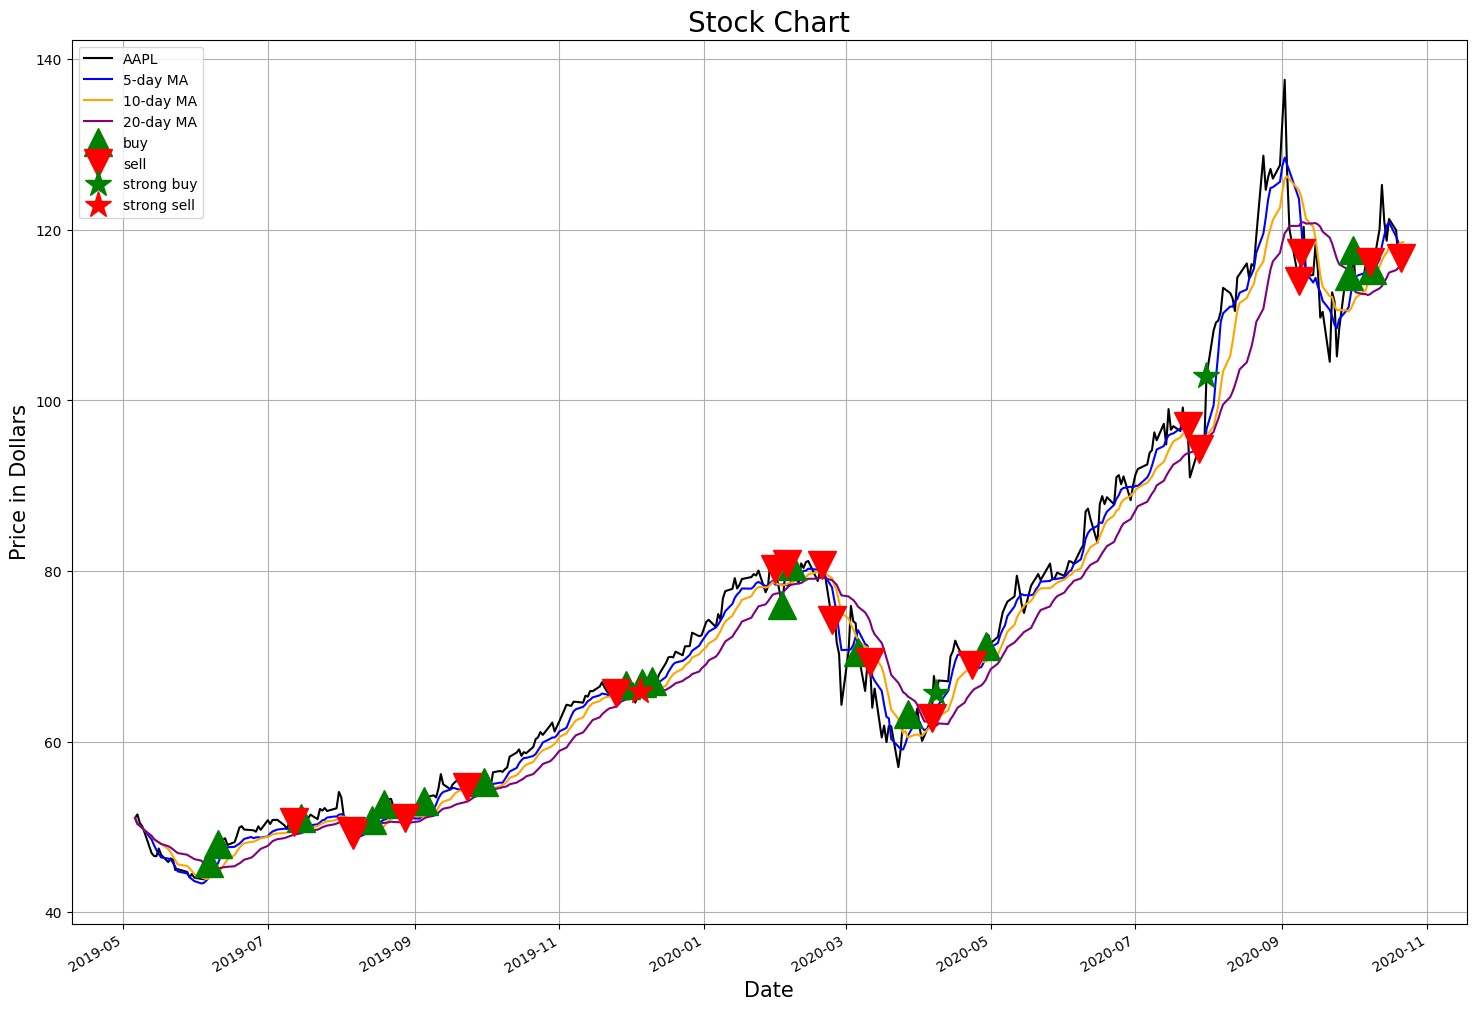

In [72]:
#plt.figure(figsize = (20,10))
plt.rcParams['figure.figsize'] = [18, 13]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

# plot close price, short-term and long-term moving averages 
daily_df_original['Open'].plot(color = 'k', label= 'Open Price') 
stock_MAs['5MA'].plot(color = 'b',label = '5-day MA') 
stock_MAs['10MA'].plot(color = 'orange', label = '10-day MA')
stock_MAs['20MA'].plot(color = 'purple', label = '20-day MA')

# plot ‘buy’ signals
plt.plot(daily_df_original[stock_df['MA_Signal_Change'] == 1].index, 
         daily_df_original['Open'][stock_df['MA_Signal_Change'] == 1], 
         '^', markersize = 20, color = 'g', label = 'buy')
# plot ‘sell’ signals
plt.plot(daily_df_original[stock_df['MA_Signal_Change'] == -1].index, 
         daily_df_original['Open'][stock_df['MA_Signal_Change'] == -1], 
         'v', markersize = 20, color = 'r', label = 'sell')

# plot ‘strong buy’ signals
plt.plot(daily_df_original[stock_df['MA_Signal_Change'] == 2].index, 
         daily_df_original['Open'][stock_df['MA_Signal_Change'] == 2], 
         '*', markersize = 20, color = 'g', label = 'strong buy')
# plot ‘strong sell’ signals
plt.plot(daily_df_original[stock_df['MA_Signal_Change'] == -2].index, 
         daily_df_original['Open'][stock_df['MA_Signal_Change'] == -2], 
         '*', markersize = 20, color = 'r', label = 'strong sell')

plt.ylabel('Price in Dollars', fontsize = 15 )
plt.xlabel('Date', fontsize = 15 )
plt.title('Stock Chart', fontsize = 20)
plt.legend()
plt.grid()
plt.show()

In [73]:
### NEW Y LABEL HERE

#monthly_df = pd.DataFrame(data=None, columns=None, index=daily_df_original.index)

## This will determine if a given day in the past was optimal to have bought or sold. 
## Using 6 months (180 days, which is close enough to 182.5) ahead of the current day to create the Y label forcast.
##
Buy_Sell_Labels = []
frame_6mo = 180
frame_3mo = 90
frame_1mo = 30
frame_2w = 10
frame_1w = 5
frame_1d = 1
for price_index in range(len(stock_close)):
    #print(price_index)
    #print(Buy_Sell_Labels)
#     ## If there is still a 1 day frame after the current day, then we can use the full future forcast labeling metric.
#     if price_index < (len(stock_close) - frame_1d):
       
    ## The first to reach 8 points is the Y label (buy/sell) for that day.
    ## Looking at 8/15 not including the consecutive combo points. 
    points_buy = 0
    points_sell = 0
    points_hold = 0

    
#     ## Checking 1 day frame.
#     ## 1 Point
#     day = price_index
    
#     sum_1d = pd.Series([])#data=None, columns=None, index=daily_df_original_y.index)
#     sum_1d['Total'] = 0
#     #print(sum_1d[0])
#     #sum_1d[0,0] = 0
#     #print(sum_1d[0])
#     #print(sum_1d[0][0])
#     #print(sum_1d.loc[0,0])
#     print("CURRENT: "+str(stock_close_y.iloc[price_index]['Close Price']))
#     sum_1d[0] = daily_df_original_y.iloc[day+1]['Adj Close'] - daily_df_original_y.iloc[day]['Adj Close'] + sum_1d[0] #sum_1d.iloc[0]
#     #print(sum_1d)
#     #print(sum_1d[0])
#     #print(sum_1d[0])
#     if sum_1d[0] >= 0:
#         points_buy += 1
#         ## combo refers to if a consecutive buy signal occured.
#         combo_buy = True
#     else:
#         points_sell += 1
#         combo_buy = False 

#     ## If there is still a 1 day frame after the current day, then we can use the full future forcast labeling metric.
#     if price_index < (len(stock_close) - frame_1d):
#     else:


    ## Checking 1 week frame.
    ## 1 Point
    sum_1d = pd.Series([], dtype='float64') #data=None, columns=None, index=daily_df_original_y.index)
    #sum_1d = pd.DataFrame([]) ..difference  between this DataFrame setup and a Series setup?
    sum_1d['Total'] = 0.0
    for day in range(price_index, price_index+frame_1w):
        #print(stock_close_y.iloc[day]['Close Price'])
        sum_1d[0] = stock_close_y.iloc[day+1]['Close Price'] - stock_close_y.iloc[day]['Close Price'] + sum_1d[0]
        #print(sum_1w[0])
    if sum_1d[0] >= 0:
        points_buy += 1
        ## combo refers to if a consecutive buy signal occured.
        combo_buy = True
    else:
        points_sell += 1
        combo_buy = False 


        
    ## Checking 2nd week frame.
    ## 2 Points
    sum_1w = sum_1d
    for day in range(price_index+frame_1w, price_index+frame_2w):
        #print(stock_close_y.iloc[day]['Close Price'])
        sum_1w[0] = stock_close_y.iloc[day+1]['Close Price'] - stock_close_y.iloc[day]['Close Price'] + sum_1w[0]
        #print(sum_1w[0])
    if sum_1w[0] > 0:
        points_buy += 2 ## Notice the extra buy point weight than the 1d signal. It changes between frames.
        ## Extra buy points earned for a consecutive buy signal.
        if combo_buy == True:
            points_buy += 1            
        ## Switching signals means volatility... so hold.
        else:
            points_hold += 4
        combo_buy = True
    else:
        points_sell += 2 ## Notice the extra sell point weight than the 1d signal. 
        ## Extra sell points earned for a consecutive sell signal.
        if combo_buy == False:
            points_sell += 1
        ## Switching signals means volatility... so hold.
        else:
            points_hold += 4
        combo_buy = False

    ## Prioritize holding during a 2 week volatility.
    if points_hold >= 8:
        Buy_Sell_Labels.append(0.0)
        continue
    else:

        ## Checking 2 week frame
        ## 3 Points
        sum_2w = sum_1w
        for day in range(price_index+frame_2w, price_index+frame_1mo):
            sum_2w[0] = daily_df_original_y.iloc[day+1]['Adj Close'] - daily_df_original_y.iloc[day]['Adj Close'] + sum_2w[0]
        if sum_2w[0] > 0:
            points_buy += 3 
            if combo_buy == True:
                points_buy += 1            
            ## Switching signals means volatility... so hold.
            else:
                points_hold += 4 ## More weight
            combo_buy = True
        else:
            points_sell += 3
            if combo_buy == False:
                points_sell += 1
            ## Switching signals means volatility... so hold.
            else:
                points_hold += 4
            combo_buy = False
            
        ## Checking points.
        if points_hold >= 8:
            Buy_Sell_Labels.append(0.0)
            continue
            
        elif points_buy >= 8:
            Buy_Sell_Labels.append(1.0)
            continue

        elif points_sell >= 8:
            Buy_Sell_Labels.append(-1.0)
            continue

        ## If there is no clear signal yet, continue...
        else:             
            
            ## Checking 1 month frame.
            ## 4 Points
            sum_1mo = sum_2w
            for day in range(price_index+frame_2w, price_index+frame_1mo):
                sum_1mo[0] = daily_df_original_y.iloc[day+1]['Adj Close'] - daily_df_original_y.iloc[day]['Adj Close'] + sum_1mo[0]
            if sum_1mo[0] > 0:
                points_buy += 4
                if combo_buy == True:
                    points_buy += 1            
                ## Switching signals means volatility... so hold.
                else:
                    points_hold += 3 ## More weight
                combo_buy = True
            else:
                points_sell += 4
                if combo_buy == False:
                    points_sell += 1
                ## Switching signals means volatility... so hold.
                else:
                    points_hold += 3
                combo_buy = False


            ## Checking points.
            if points_hold >= 8:
                Buy_Sell_Labels.append(0.0)
                continue

            elif points_buy >= 8:
                Buy_Sell_Labels.append(1.0)
                continue

            elif points_sell >= 8:
                Buy_Sell_Labels.append(-1.0)
                continue

            ## If there is no clear signal yet, continue...
            else:       
                ## Checking 3 month frame.
                ## 3 Points
                sum_3mo = sum_1mo
                for day in range(price_index+frame_1mo, price_index+frame_3mo):
                    sum_3mo[0] = daily_df_original_y.iloc[day+1]['Adj Close'] - daily_df_original_y.iloc[day]['Adj Close'] + sum_3mo[0]
                if sum_3mo[0] > 0:
                    points_buy += 3
                    if combo_buy == True:
                        points_buy += 1            
                    ## Switching signals means volatility... so hold.
                    else:
                        points_hold += 3
                    combo_buy = True
                else:
                    points_sell += 3
                    if combo_buy == False:
                        points_sell += 1
                    ## Switching signals means volatility... so hold.
                    else:
                        points_hold += 3
                    combo_buy = False

                ## Checking points.
                if points_hold >= 8:
                    Buy_Sell_Labels.append(0.0)
                    continue

                elif points_buy >= 8:
                    Buy_Sell_Labels.append(1.0)
                    continue

                elif points_sell >= 8:
                    Buy_Sell_Labels.append(-1.0)
                    continue

                ## If there is no clear signal yet, continue...
                else: 
                    ## Checking 6 month frame.
                    ## 2 Points
                    sum_6mo = sum_3mo
                    for day in range(price_index+frame_3mo, price_index+frame_6mo):
                        sum_6mo[0] = daily_df_original_y.iloc[day+1]['Adj Close'] - daily_df_original_y.iloc[day]['Adj Close'] + sum_6mo[0]
                    if sum_6mo[0] > 0:
                        points_buy += 2
                        if combo_buy == True:
                            points_buy += 1            
                        ## Switching signals means volatility... so hold.
                        else:
                            points_hold += 3
                        combo_buy = True
                    else:
                        points_sell += 2
                        if combo_buy == False:
                            points_sell += 1
                        ## Switching signals means volatility... so hold.
                        else:
                            points_hold += 3
                        combo_buy = False

                    ## Last check.
                    if points_hold >= 8:
                        Buy_Sell_Labels.append(0.0)
                        continue

                    elif points_buy >= 8:
                        Buy_Sell_Labels.append(1.0)
                        continue

                    elif points_sell >= 8:
                        Buy_Sell_Labels.append(-1.0)
                        continue

                    else:
                        Buy_Sell_Labels.append(0.0)
                        continue
        
        
stock_df['Buy_Sell_Labels'] = Buy_Sell_Labels     
stock_df = stock_df.fillna(0)


In [74]:
print(stock_df.shape) 
print(len(Buy_Sell_Labels))
print(Buy_Sell_Labels)

(372, 36)
372
[-1.0, -1.0, -1.0, -1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, -1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, 0.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0

In [75]:
# monthly_df = pd.DataFrame(data=None, columns=None, index=daily_df_original.index)

# monthly_df.insert(0,'High',monthly_df_original['High'])
# monthly_df.insert(1,'Low',monthly_df_original['Low'])

# ## Fills the NaN missing values with the last valid value.
# ## This allows the lowest and highest values of the month populate each day, so to allow comparison to the daily dataframe.
# monthly_df = monthly_df.fillna(method='bfill') 
# #monthly_df.insert(2,'Close',stock_close['Close Price'])

# monthly_highest = monthly_df['High']
# monthly_lowest = monthly_df['Low']
# monthly_average = (monthly_lowest + monthly_highest)/2
# monthly_25th_high_percentile = (monthly_average+monthly_highest)/2
# monthly_df['25% Highest'] = monthly_25th_high_percentile
# monthly_25th_low_percentile = (monthly_average+monthly_lowest)/2
# monthly_df['25% Lowest'] = monthly_25th_low_percentile

# #stock_df['15EMA_Signal'] = np.where(stock_EMAs['EMA10'] > stock_EMAs['EMA15'], 1.0, 0.0)

# #if bollinger_df.iloc[0][symbol] <= bollinger_df.iloc[0]['Lower Bollinger Band']:


# #stock_df['15EMA_Signal'] = np.where(stock_EMAs['EMA10'] > stock_EMAs['EMA15'], 1.0, 0.0)

# Buy_Sell_Labels = []
# for price_index in range(len(monthly_df)):
#     if (stock_close.iloc[price_index]['Close Price'] >= monthly_df.iloc[price_index]['25% Highest']): # & (monthly_df.iloc[0]['Close'] >= monthly_25th_high_percentile):
#         Buy_Sell_Labels.append(1.0)        

#     elif (stock_close.iloc[price_index]['Close Price'] <= monthly_df.iloc[price_index]['25% Lowest']): #& (monthly_df.iloc[price_index]['Close'] <= monthly_25th_low_percentile):
#         Buy_Sell_Labels.append(-1.0)

#     else:
#         Buy_Sell_Labels.append(0.0)
        
        
# stock_df['Buy_Sell_Labels'] = Buy_Sell_Labels     
# stock_df = stock_df.fillna(0)

# # for price_index in range(len(monthly_df)):
# #     if (stock_close.iloc[price_index]['Close Price'] >= monthly_df.iloc[price_index]['25% Highest']): # & (monthly_df.iloc[0]['Close'] >= monthly_25th_high_percentile):
# #         stock_df.loc['Buy_Sell_Labels'] = 1
# #         #stock_df = monthly_df.fillna(method='ffill') 


# #     elif (stock_close.iloc[price_index]['Close Price'] <= monthly_df.iloc[price_index]['25% Lowest']): #& (monthly_df.iloc[price_index]['Close'] <= monthly_25th_low_percentile):
# #         stock_df.loc['Buy_Sell_Labels'] = -1

# #     else:
# #         stock_df.loc['Buy_Sell_Labels'] = 0
    

In [76]:
# monthly_df.head(10)

In [77]:
# stock_close.iloc[100]['Close Price']
# #stock_close.tail(10)

In [78]:
# monthly_df.iloc[100]['25% Highest']

In [79]:
# #stock_close.iloc[100]['Close Price'] >= monthly_df.iloc[100]['25% Highest']
# stock_close.iloc[100]['Close Price'] <= monthly_df.iloc[100]['25% Lowest']

In [80]:
stock_df[100:101]

,10MA_Signal,20MA_Signal,10MA_Signal_Change,20MA_Signal_Change,MA_Signal_Change,Distance_of_Low_to_5MA,ROC_of_Low_to_5MA,Distance_of_High_to_5MA,ROC_of_High_to_5MA,Distance_of_Low_to_10MA,...,Distance_of_EMA9_to_MACD,ROC_of_EMA9_to_MACD,MACD_Signal,MACD_Signal_Change,15EMA_Signal,20EMA_Signal,30EMA_Signal,15EMA_Signal_Change,EMA_Signal_Change,Buy_Sell_Labels
Date,,,,,,,,,,,,,,,,,,,,,
2019-09-26,0.0,1.0,0.0,0.0,0.0,0.667037,0.245335,1.194537,0.475305,0.468898,...,-0.750003,-0.017558,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


In [81]:
# len(monthly_df)

In [82]:
# range(len(monthly_df))

In [83]:
stock_df[:]

,10MA_Signal,20MA_Signal,10MA_Signal_Change,20MA_Signal_Change,MA_Signal_Change,Distance_of_Low_to_5MA,ROC_of_Low_to_5MA,Distance_of_High_to_5MA,ROC_of_High_to_5MA,Distance_of_Low_to_10MA,...,Distance_of_EMA9_to_MACD,ROC_of_EMA9_to_MACD,MACD_Signal,MACD_Signal_Change,15EMA_Signal,20EMA_Signal,30EMA_Signal,15EMA_Signal_Change,EMA_Signal_Change,Buy_Sell_Labels
Date,,,,,,,,,,,,,,,,,,,,,
2019-05-06,0.0,0.0,0.0,0.0,0.0,-0.175892,0.000000,1.159107,0.000000,-0.175892,...,-1.640282,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
2019-05-07,0.0,0.0,0.0,0.0,0.0,-0.155300,0.020592,1.492199,0.020592,-0.155300,...,-1.657435,-0.017153,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
2019-05-08,0.0,0.0,0.0,0.0,0.0,0.300800,0.456100,1.198299,0.456100,0.300800,...,-1.666405,-0.008969,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
2019-05-09,0.0,0.0,0.0,0.0,0.0,-0.725195,-1.025995,0.529802,-1.025995,-0.725195,...,-1.678242,-0.011838,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
2019-05-10,0.0,0.0,0.0,0.0,0.0,-1.413612,-0.688417,0.106388,-0.688417,-1.413612,...,-1.696355,-0.018112,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-16,1.0,1.0,0.0,0.0,0.0,-2.084462,0.052952,0.655544,0.251314,0.879986,...,-0.677724,0.169431,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
2020-10-19,1.0,1.0,0.0,0.0,0.0,-3.555864,-3.444046,1.204131,-1.471402,-2.218176,...,-0.601846,0.075878,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
2020-10-20,1.0,1.0,0.0,0.0,0.0,-2.870180,-0.314092,0.479826,0.685684,-2.681786,...,-0.566617,0.035228,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


In [84]:
stock_df.info() ## Check for any categorical feature

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 372 entries, 2019-05-06 to 2020-10-22
Data columns (total 36 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   10MA_Signal                       372 non-null    float64
 1   20MA_Signal                       372 non-null    float64
 2   10MA_Signal_Change                372 non-null    float64
 3   20MA_Signal_Change                372 non-null    float64
 4   MA_Signal_Change                  372 non-null    float64
 5   Distance_of_Low_to_5MA            372 non-null    float64
 6   ROC_of_Low_to_5MA                 372 non-null    float64
 7   Distance_of_High_to_5MA           372 non-null    float64
 8   ROC_of_High_to_5MA                372 non-null    float64
 9   Distance_of_Low_to_10MA           372 non-null    float64
 10  Distance_of_High_to_10MA          372 non-null    float64
 11  ROC_of_High_to_10MA               372 non-null    fl

In [85]:
print(stock_df.isnull().sum())


10MA_Signal                         0
20MA_Signal                         0
10MA_Signal_Change                  0
20MA_Signal_Change                  0
MA_Signal_Change                    0
Distance_of_Low_to_5MA              0
ROC_of_Low_to_5MA                   0
Distance_of_High_to_5MA             0
ROC_of_High_to_5MA                  0
Distance_of_Low_to_10MA             0
Distance_of_High_to_10MA            0
ROC_of_High_to_10MA                 0
Distance_of_Low_to_20MA             0
Distance_of_High_to_20MA            0
High_BOLL_Signal                    0
Low_BOLL_Signal                     0
Distance_of_High_to_High_BOLL       0
ROC_of_High_to_High_BOLL            0
Distance_of_Close_to_High_BOLL      0
ROC_of_Close_to_High_BOLL           0
Distance_of_Low_to_Low_BOLL         0
ROC_of_Low_to_Low_BOLL              0
Distance_of_Close_to_Low_BOLL       0
ROC_of_Close_to_Low_BOLL            0
Distance_of_Close_to_Future_MACD    0
ROC_of_Close_to_Future_MACD         0
Distance_of_

In [86]:
## X ... axis=1 is for choosing to drop/remove the column values from the data frame matrix
X = stock_df.drop('Buy_Sell_Labels', axis=1).values
### X is the target values

## y ... this takes those values dropped and assigns it to the GROUND TRUTH "y" label 
y_ = stock_df['Buy_Sell_Labels'].values

## Labels are already normalized, so this is a redundant step.
y = y_ / np.max(y_)
### y is the target labels

print(y)
print(y==y_)
print(y.shape)
y[100:150]

[-1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0. -1.  1.
  1.  1.  1.  1.  1.  0.  1.  1.  1.  1.  1.  0.  1.  1.  1.  1.  1.  1.
  1.  0.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1.  0. -1. -1. -1. -1. -1.
 -1. -1.  0.  0. -1.  0. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1.  1. -1. -1. -1. -1. -1. -1.  1. -1. -1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [89]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X,
                                                            y,
                                                            test_size=72,
                                                            random_state=0)


print("train_val: {}, test: {}".format(X_train_val.shape[0], X_test.shape[0]))

normalizer = StandardScaler()
X_train_val = normalizer.fit_transform(X_train_val)
X_test = normalizer.transform(X_test)

train_val: 300, test: 72


In [90]:
# here we use 10-fold cross-validation
folds = 10

# get the number of samples in the training and validation set
num_train_val = X_train_val.shape[0] 

# shuffle the index of samples in the train_val set
index_of_samples = np.arange(num_train_val) 
shuffle(index_of_samples)

# split the index of the train_valid set into 10 folds
index_of_folds = index_of_samples.reshape(folds, -1)
print(index_of_folds)

# potential hyperparameters. 
#These hyperparameters are just used for illustration. 
#You should try more hyperparameters to get a good model.
#The hyperparameters must be nonnegative!
regularization_coefficient = [10**-5,10**-4,10**-3,10**-2,10**-1,1.0,10,20,50,100]

best_acc = 0.0
best_reg = 0.0

for reg in regularization_coefficient:
    
    # 10-fold cross-validation
    sum_acc = 0.0
    for fold in range(folds):
        
        index_of_folds_temp = index_of_folds.copy()
        
        valid_index = index_of_folds_temp[fold,:].reshape(-1) #get the index of the validation set
        train_index = np.delete(index_of_folds_temp, fold, 0).reshape(-1) #get the index of the training set
        
        # training set
        X_train = X_train_val[train_index]
        y_train = y_train_val[train_index]
        
        # validation set
        X_valid = X_train_val[valid_index]
        y_valid = y_train_val[valid_index]
                
        # build the model with different hyperparameters
        ## 'l2'-regularizer , C = regularization coefficient
        ## 'lbfgs' is for L2
        clf = LogisticRegression(penalty='l2', C=reg, solver='lbfgs',max_iter=10000)
        
        #train the model with the training set
        clf.fit(X_train, y_train)
        
        y_valid_pred = clf.predict(X_valid)
        acc = accuracy_score(y_valid, y_valid_pred)
        
        sum_acc += acc
        
        coefficient_list = clf.coef_
    
    cur_acc = sum_acc / folds
    
    print("reg: {}, reg_coeff: {}, acc: {:.3f}".format(reg, 1.0/reg, cur_acc))
    
    # store the best hyperparameter
    if cur_acc > best_acc:
        best_acc = cur_acc
        best_reg = reg
print("best_reg: {}".format(best_reg))

[[252   9  87 286 169 127  63 180 231 282 198 210 211  56 225 293  97 284
  108 154 206 119  12  79 200 276  80 153 192 147]
 [214 164 195 281 148  70  23 260 122 134  51 272 104 144 264  68 188 151
  166 138 140 197  62 142 190  53 189 253   1 226]
 [239 230  84  61  98 159  88 114  40  77  29 129  24 117  76 263  25 267
  109 178  50  33 219 290  31 112 181 183 265 269]
 [ 28 270 288  13 268 279 243  71 177 257 145  66 157 205 207 254  54  38
  115 232  91  92 186 121 173  57 278 292 266 245]
 [ 17 250 155 294 179  75 102  42  30 212  32  94 201  74  37  78 215 132
   14  20  60 236  36 167 238  41 255  89 106 222]
 [143 234 120 224  82   7 202 191 218 241 187 182 110 242 296 176 235  16
  158  27 280 237 162 249 285 248 204  65   5  49]
 [233  34   2  11 118  96 113 258  39  45 123 139  59 184 256 126  73 246
   15 217 128 295 103  58  90 275  93 160 271 150]
 [ 48   4 221 199 146  99 116 273 261 100 141  86  85  43  67 168 262  21
  209 185  46 251 277 216   8 130  95 107 171 133]


In [91]:
## your code

clf = LogisticRegression(penalty='l2', C=best_reg, solver='lbfgs',max_iter=10000)
clf.fit(X_train_val, y_train_val)

# evaluate the model on the testing set
y_test_pred = clf.predict(X_test)

print(classification_report(y_test, y_test_pred))

# acc = accuracy_score(y_test, y_test_pred)
# f1 = f1_score(y_test, y_test_pred)
# recall = recall_score(y_test, y_test_pred)
# precision = precision_score(y_test, y_test_pred)

# ## This perfect performance is realalistically impossible
# print("accuracy: {:.3f}, recall: {:.3f}, precision: {:.3f}, f1: {:.3f},".format(acc, recall, precision, f1))

              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00         2
         0.0       0.00      0.00      0.00         3
         1.0       0.93      1.00      0.96        67

    accuracy                           0.93        72
   macro avg       0.31      0.33      0.32        72
weighted avg       0.87      0.93      0.90        72



c:\users\s c a p e z a r\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\s c a p e z a r\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\s c a p e z a r\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

In [92]:
round(clf.score(X,y), 5)

0.79032

In [93]:
regressor = RandomForestRegressor(n_estimators=20, random_state=0)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.22708333333333336
Mean Squared Error: 0.15045138888888887
Root Mean Squared Error: 0.3878806374245676
